# Top Cell is the last version

In [1]:
"""
Created on Wed Nov 29 16:22:04 2017

@author: aarono
"""

#modified from Agata's transgenic daily report

#import all the things
import fnmatch
import matplotlib.dates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.dates
from matplotlib.dates import HOURLY, DateFormatter, rrulewrapper, RRuleLocator
import seaborn as sns
import os
import pg8000
import json
from pandas.io.json import json_normalize
from datetime import datetime, timedelta, date
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar


def get_jsons(dirname, expt, delta_days):
    """Return filepaths of metadata files that were created within
    delta_days of today.
    
    Parameters
    ----------
    dirname : string
        Path to metadata file directory.
    expt : string
        Experiment type for filename match ("PS" or "IVSCC").
    delta_days : int
        A number of days in the past.

    Returns
    -------
    json_paths : list
        A list of filepaths that are a expt string match and were
        created within delta_days of today.
    """

    json_paths = []
    comparison_date = datetime.today()
    
    for jfile in os.listdir(dirname):
        if fnmatch.fnmatch(jfile,'*.%s.json' %expt):
            jpath = os.path.join(dirname, jfile)
            created_date = datetime.fromtimestamp(os.path.getctime(jpath))
            if abs((comparison_date - created_date ).days) < delta_days:
                json_paths.append(jpath)
    return json_paths

def flatten_attempts(slice_info, form_version):
    """Return flattened slice metadata dataframe.
    
    Parameters
    ----------
    slice_info : dict
        A dictionary of slices with nested pipette attempts.
    
    form_version : string
        A string containing the JEM form version.
        (Pre-version 2 contains IVSCC, PatchSeq and Electroporation arrays)
    Returns
    -------
    attempts_slice_df : pandas dataframe
        A dataframe of all pipette attempts along with all slice metadata.
    """
    
    df = json_normalize(slice_info)
    if form_version >= "2":
        ps_array_name = "pipettes"
    else:
        ps_array_name = "pipettesPatchSeqPilot"
    
    try:
        attempts_df = json_normalize(slice_info[ps_array_name])
        attempts_df["limsSpecName"] = df["limsSpecName"].values[0]
        attempts_df["attempt"] = [p+1 for p in attempts_df.index.values]
        attempts_slice_df = pd.merge(df, attempts_df, how="outer", on="limsSpecName")
        attempts_slice_df.drop(ps_array_name, axis=1, inplace=True)
        return attempts_slice_df
    except IndexError:
        pass
    
def is_field(df, colname):
    """Determine whether a column name exists in a dataframe.
    
    Parameters
    ----------
    df : a Pandas dataframe
    colname : string
        
    Returns
    -------
    Boolean
        Boolean value indicating if the colname exists in the dataframe.
    """
    
    try:
        df[colname]
        return True
    except KeyError:
        return False
    
def normalize_dates(df):
    """Normalize date format in available date fields (from different JEM versions) as "MM/DD/YYYY".
    
    Parameters
    ----------
    df : a Pandas dataframe
        
    Returns
    -------
    df : a Pandas dataframe
    """
    
    date_fields =["acsfProductionDate", "internalFillDate", "blankFillDate"]
    for d in date_fields:
        if is_field(df, d):
            df[d] = df[d].apply(normalize_MMDDYYYY)            
    return df

def normalize_MMDDYYYY(val):
    """Determine whether a value is a string in the correct MMDDYYYY format, and if not, convert it.
    
    Parameters
    ----------
    val : string or np.nan
        
    Returns
    -------
    val : string or np.nan
    
    """
    
    try:
        datetime.strptime(val, "%m/%d/%Y")
        return val
    except TypeError:
        return np.nan
    except ValueError:
        if len(val) == 8:
            return datetime.strptime(val, "%m/%d/%y").strftime("%m/%d/%Y")
        else:
            return val
        
def select_report_date_attempts(df, report_dt):
    """Return recordings from a specific report_date, or between two report dates.
    
    Parameters
    ----------
    df : pandas dataframe
        A dataframe of PatchSeq recording attempts.
    report_dt : list
        A list of datetime.date values
        
    Returns
    -------
    df : pandas dataframe
        A dataframe of PatchSeq recording attempts from the report date.
    """
    
    df["date_dt"] = df["date"].apply(lambda x: pd.to_datetime(x).date())
    if len(report_dt) == 1:
        df = df[df["date_dt"] == report_dt[0]]
    else:
        df = df[(df["date_dt"] >= report_dt[0]) & (df["date_dt"] <= report_dt[1])]
    return df

def get_specimen(slice_name):
    #defines the specimen name
    if slice_name[:3] == 'H17' or slice_name[:3] == 'H18':
        return slice_name[:10]
    else:
        return slice_name[:-6]
    
def create_time(time):
    """Creates the time"""
 
    time = datetime.strptime(time, "%H:%M:%S")
    time = matplotlib.dates.date2num(time)

    return time


#1 color per mouse/human case with a couple extra colors to allow for typos and extra tissue
spec_colors = {
    0: '#1b9e77',
    1: '#d95f02',
    2: '#7570b3',
    3: '#e7298a',
    4: '#66a61e',
    5: '#e6ab02',
    6: '#a6761d',
    7: '#666666'
}

#pull the data from the jsons
"""
what do I need to collect from each json?
1. slice name
2. date
3. user
4. time on rig
5. attempts
    5a. approach start
    5b. approach outcome
    5c. patch end
"""
DEFAULT_DIR = "//allen/programs/celltypes/workgroups/279/Patch-Seq/all-metadata-files"

#get the last business day to run the calendar on 
bday_us = CustomBusinessDay(calendar=USFederalHolidayCalendar())
last_bday = (datetime.today() - bday_us).date()
last_bday_str = last_bday.strftime("%y%m%d")

report_dt = last_bday
delta_mod_date = (datetime.today().date() - report_dt).days + 3
json_paths = get_jsons(dirname=DEFAULT_DIR, expt="PS", delta_days=delta_mod_date)

json_df = pd.DataFrame()
for json_path in json_paths:
    with open(json_path) as data_file:
        slice_info = json.load(data_file)
        jem_version = slice_info["formVersion"]
        flat_df = flatten_attempts(slice_info, jem_version)
        json_df = pd.concat([json_df, flat_df], axis=0)

#put the data together

p_user_map = {"Kristen Hadley":"kristenh",
           "Rusty Mann":"rustym",
           "Jonathan Ting":"jonathant",
           "Brian Lee":"brianle",
           "Aaron Oldre":"aarono",
           "Brian Kalmbach":"briank",
           "Lindsay Ng":"lindsayn",
           "Lisa Kim": "lisak",
           "Ram Rajanbabu":"ramr",
           "DiJon Hill":"dijonh"}

p_users = {"kristenh":"P1",
           "rustym":"P2",
           "jonathant":"P3",
           "brianle":"P5",
           "aarono":"P6",
           "briank":"P7",
           "lindsayn":"P8",
           "lisak": "P9",
           "ramr":"PA",
           "dijonh":"PB"}

prod_users = ["kristenh",
           "rustym",
           "lindsayn",
           "lisak",
           "ramr",
           "dijonh"]

if len(json_df) > 0:
    json_df.replace({"rigOperator": p_user_map}, inplace=True)
    json_df = normalize_dates(json_df)
    json_df = json_df[json_df["rigOperator"].isin(p_users.keys())] 
    json_df = select_report_date_attempts(json_df, [report_dt])
    json_df.reset_index(drop=True, inplace=True)
    json_df = json_df[json_df['approach.pilotName'] != 'Tissue_Touch']
    
qc_df = json_df[['date', 'attempt', 'limsSpecName', 'rigOperator', 'extraction.nucleus', 
                'extraction.postPatch', 'extraction.timeExtractionEnd', 'extraction.timeRetractionEnd', 'failureNotes',
                'recording.timeStart', 'recording.timeWholeCellStart', 'status', 'sliceQuality']]

#remove all development users from the dataframe
qc_df = qc_df[qc_df['rigOperator'].isin(prod_users)]

qc_df['specimen'] = qc_df['limsSpecName'].map(lambda x: get_specimen(x))
qc_df = qc_df.sort(['date', 'specimen'])
qc_df['date'] = qc_df['date'].map(lambda x: x if type(x) == float else x.split(' -08:00')[0])
qc_df['extraction.timeExtractionEnd'] = qc_df['extraction.timeExtractionEnd'].map(lambda x: x if type(x) == float else x.split(' -08:00')[0])
qc_df['recording.timeWholeCellStart'] = qc_df['recording.timeWholeCellStart'].map(lambda x: x if type(x) == float else x.split(' -08:00')[0])
qc_df['extraction.timeRetractionEnd'] = qc_df['extraction.timeRetractionEnd'].map(lambda x: x if type(x) == float else x.split(' -08:00')[0])
qc_df['recording.timeStart'] = qc_df['recording.timeStart'].map(lambda x: x if type(x) == float else x.split(' -08:00')[0])

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)

#grab a list of users that were patching that day
daily_users = list(qc_df.rigOperator.unique())

for user in qc_df.rigOperator.unique():
    user_df = qc_df[qc_df['rigOperator'] == user]
    for spec in user_df.specimen.unique():
        spec_df = user_df[user_df['specimen'] == spec]
        color = spec_colors[list(qc_df.specimen.unique()).index(spec)]
        y = daily_users.index(user)
        for index, slce in spec_df.iterrows():
            slce['date'] = slce['date'].split(' ')[1]
            
            if slce['status'] == 'SUCCESS':
                ax.barh(y, create_time(slce['extraction.timeRetractionEnd']) - create_time(slce['recording.timeStart']),
                         left = create_time(slce['recording.timeStart']), color = color)
                if slce['attempt'] == spec_df[spec_df['limsSpecName'] == slce['limsSpecName']]['attempt'].max():
                    ax.barh(y, create_time(slce['extraction.timeRetractionEnd']) - create_time(slce['date']),
                         left = create_time(slce['date']), color = color,alpha = .2, label = slce['specimen'])
                    if slce['sliceQuality'] != 'Good':
                        ax.scatter([create_time(slce['date'])],y, 
                              color = color, marker = r'$\spadesuit$')
                    else:
                        ax.scatter([create_time(slce['date'])],y, 
                              color = color, marker = r'$\heartsuit$')
            if slce['status'] == 'FAILURE':
                ax.barh(y, create_time(slce['recording.timeWholeCellStart']) - create_time(slce['recording.timeStart']), 
                         left = create_time(slce['recording.timeStart']), color = color, alpha = .4)
                if slce['attempt'] == spec_df[spec_df['limsSpecName'] == slce['limsSpecName']]['attempt'].max():
                    ax.barh(y, create_time(slce['recording.timeWholeCellStart']) - create_time(slce['date']),
                         left = create_time(slce['date']), color = color,alpha = .2, label = slce['specimen'])
                    if slce['sliceQuality'] != 'Good':
                        ax.scatter([create_time(slce['date'])],y, 
                              color = color, marker=r'$\spadesuit$')
                    else:
                        ax.scatter([create_time(slce['date'])],y, 
                              color = color, marker = r'$\heartsuit$')
            
                

                    
#change the x ticks back to date format
#start x at 9:00 since that is when first tissue is available
#can be adjusted for future instances where tissue is available earlier
ax.set_xlim(create_time("9:00:00"),create_time("18:00:00"))
ax.xaxis_date()
rule = rrulewrapper(HOURLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter("%H:%M")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
labelsx = ax.get_xticklabels()
plt.setp(labelsx, rotation=45, fontsize=12)

#add user ID to the y ticks. Use the dictionary to switch from names to IDs
plt.yticks(np.arange(0,qc_df.rigOperator.nunique()), [p_users[i] for i in qc_df.rigOperator.unique()])
#plt.legend()
sns.despine()
#plt.savefig(os.path.join('z:/','daily_qc', last_bday_str + '.pdf'))

C:\Users\aarono\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:284: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# This cell will only work after the previous cell has loaded the data

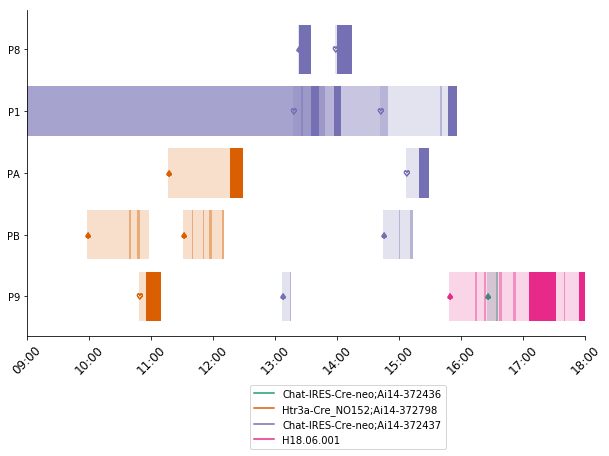

In [3]:
%matplotlib inline
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)

#grab a list of users that were patching that day
daily_users = list(qc_df.rigOperator.unique())

for user in qc_df.rigOperator.unique():
    user_df = qc_df[qc_df['rigOperator'] == user]
    for spec in user_df.specimen.unique():
        spec_df = user_df[user_df['specimen'] == spec]
        color = spec_colors[list(qc_df.specimen.unique()).index(spec)]
        y = daily_users.index(user)
        for index, slce in spec_df.iterrows():
            slce['date'] = slce['date'].split(' ')[1]
            
            if slce['status'] == 'SUCCESS':
                ax.barh(y, create_time(slce['extraction.timeRetractionEnd']) - create_time(slce['recording.timeStart']),
                         left = create_time(slce['recording.timeStart']), color = color)
                if slce['attempt'] == spec_df[spec_df['limsSpecName'] == slce['limsSpecName']]['attempt'].max():
                    ax.barh(y, create_time(slce['extraction.timeRetractionEnd']) - create_time(slce['date']),
                         left = create_time(slce['date']), color = color,alpha = .2)
                    if slce['sliceQuality'] != 'Good':
                        ax.scatter([create_time(slce['date'])],y, 
                              color = color, marker = r'$\spadesuit$')
                    else:
                        ax.scatter([create_time(slce['date'])],y, 
                              color = color, marker = r'$\heartsuit$')
            if slce['status'] == 'FAILURE':
                ax.barh(y, create_time(slce['recording.timeWholeCellStart']) - create_time(slce['recording.timeStart']), 
                         left = create_time(slce['recording.timeStart']), color = color, alpha = .4)
                if slce['attempt'] == spec_df[spec_df['limsSpecName'] == slce['limsSpecName']]['attempt'].max():
                    ax.barh(y, create_time(slce['recording.timeWholeCellStart']) - create_time(slce['date']),
                         left = create_time(slce['date']), color = color,alpha = .2)
                    if slce['sliceQuality'] != 'Good':
                        ax.scatter([create_time(slce['date'])],y, 
                              color = color, marker=r'$\spadesuit$')
                    else:
                        ax.scatter([create_time(slce['date'])],y, 
                              color = color, marker = r'$\heartsuit$')
            
                

                    
#add legend and position it below the graph
for spec in qc_df.specimen.unique():
    plt.plot([],[],color = spec_colors[list(qc_df.specimen.unique()).index(spec)], label = spec)

plt.legend(bbox_to_anchor=(.75, -.15), loc=0, borderaxespad=0.) 

#change the x ticks back to date format
#start x at 9:00 since that is when first tissue is available
#can be adjusted for future instances where tissue is available earlier
ax.set_xlim(create_time("9:00:00"),create_time("18:00:00"))
ax.xaxis_date()
rule = rrulewrapper(HOURLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter("%H:%M")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
labelsx = ax.get_xticklabels()
plt.setp(labelsx, rotation=45, fontsize=12)

#add user ID to the y ticks. Use the dictionary to switch from names to IDs
plt.yticks(np.arange(0,qc_df.rigOperator.nunique()), [p_users[i] for i in qc_df.rigOperator.unique()])
sns.despine()
#plt.savefig(os.path.join('z:/','daily_qc', last_bday_str + '.pdf'))

# Slice usage as a whole

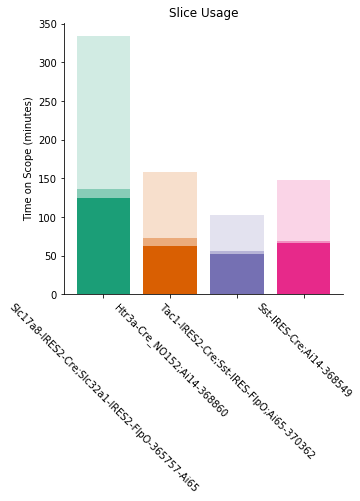

In [62]:
fig = plt.figure(figsize = (5,5))

#how to grab the percentages?
for spec in qc_df.specimen.unique():
    spec_df = qc_df[qc_df['specimen'] == spec]
    slice_on = 0
    attempts = 0
    patches= 0
    for user in qc_df.rigOperator.unique():
        user_df = spec_df[spec_df['rigOperator'] == user]
        for index, slce in user_df.iterrows():
            slce['date'] = slce['date'].split(' ')[1]
            if slce['status'] == 'SUCCESS':
                minutes = (create_time(slce['extraction.timeRetractionEnd']) - create_time(slce['recording.timeStart'])) *24*60
                #decimal is a percentage of a day
                patches += minutes
                if slce['attempt'] == spec_df[spec_df['limsSpecName'] == slce['limsSpecName']]['attempt'].max():
                    minutes = (create_time(slce['extraction.timeRetractionEnd']) - create_time(slce['date']))*24*60
                    slice_on += minutes
            if slce['status'] == 'FAILURE':
                minutes = (create_time(slce['recording.timeWholeCellStart']) - create_time(slce['recording.timeStart'])) *24*60
                attempts += minutes
                if slce['attempt'] == spec_df[spec_df['limsSpecName'] == slce['limsSpecName']]['attempt'].max():
                    minutes = (create_time(slce['recording.timeWholeCellStart']) - create_time(slce['date'])) *24*60
                    slice_on += minutes
    
    color = spec_colors[list(qc_df.specimen.unique()).index(spec)]
    x =  list(qc_df.specimen.unique()).index(spec)
    plt.bar(x, slice_on, color = color, alpha = .2)
    plt.bar(x, patches, color = color)
    plt.bar(x, attempts, bottom = patches, color = color, alpha = .4)

plt.xticks(np.arange(0,qc_df.specimen.nunique()), [i for i in qc_df.specimen.unique()], rotation = -45)
plt.ylabel('Time on Scope (minutes)')
plt.title('Slice Usage')
sns.despine()   
#plt.savefig(os.path.join('z:/','daily_qc', last_bday_str + '_overall_time.png'))

# One last concept for looking at the numbers

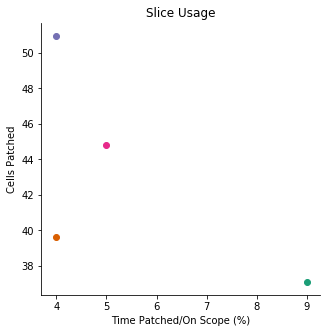

In [64]:
fig = plt.figure(figsize = (5,5))

#how to grab the percentages?
for spec in qc_df.specimen.unique():
    spec_df = qc_df[qc_df['specimen'] == spec]
    slice_on = 0
    patches= 0
    for user in qc_df.rigOperator.unique():
        user_df = spec_df[spec_df['rigOperator'] == user]
        for index, slce in user_df.iterrows():
            slce['date'] = slce['date'].split(' ')[1]
            if slce['status'] == 'SUCCESS':
                minutes = (create_time(slce['extraction.timeRetractionEnd']) - create_time(slce['recording.timeStart'])) *24*60
                #decimal is a percentage of a day
                patches += minutes
                if slce['attempt'] == spec_df[spec_df['limsSpecName'] == slce['limsSpecName']]['attempt'].max():
                    minutes = (create_time(slce['extraction.timeRetractionEnd']) - create_time(slce['date']))*24*60
                    slice_on += minutes
            if slce['status'] == 'FAILURE':
                if slce['attempt'] == spec_df[spec_df['limsSpecName'] == slce['limsSpecName']]['attempt'].max():
                    minutes = (create_time(slce['recording.timeWholeCellStart']) - create_time(slce['date'])) *24*60
                    slice_on += minutes
    
    color = spec_colors[list(qc_df.specimen.unique()).index(spec)]
    x =  list(qc_df.specimen.unique()).index(spec)
    plt.scatter(len(spec_df[spec_df['status'] == 'SUCCESS']), patches/slice_on*100, color = color)
    
plt.ylabel('Time Patched/On Scope (%)')
plt.xlabel('Cells Patched')
plt.title('Slice Usage')
sns.despine()   
#plt.savefig(os.path.join('z:/','daily_qc', last_bday_str + '_overall_time.png'))